# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Загрузка датасета

In [3]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [4]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

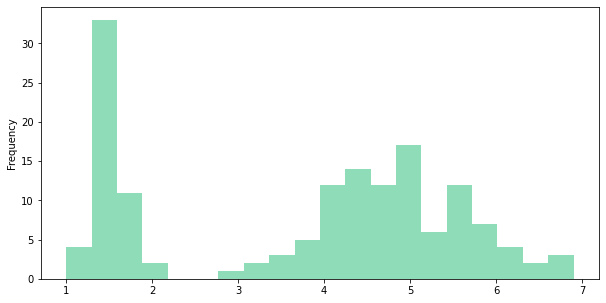

In [5]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [6]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

<ipython-input-10-6853d5fad439>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["petal.length"][data["petal.length"]<=2.8] = np.random.normal(loc= data["petal.length"][data["petal.length"]<=2.8].median(),#loc=5.0,


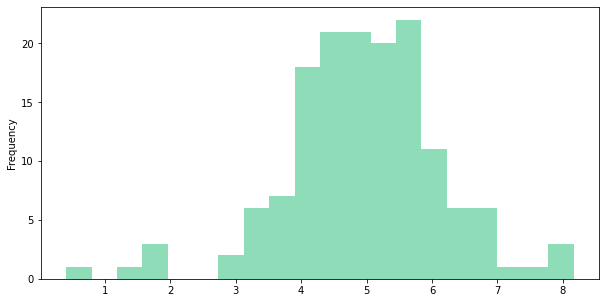

In [10]:
data["petal.length"][data["petal.length"]<=2.8] = np.random.normal(loc= data["petal.length"][data["petal.length"]<=2.8].median(),#loc=5.0, 
                                                        scale=data["petal.length"].std(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8]))
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [11]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,7.809963
1,1.4,8.162901
2,1.3,0.411909
3,1.5,5.584020
4,1.4,4.927634
5,1.7,1.414470
6,1.4,6.264424
7,1.5,3.717298
8,1.4,1.706745
9,1.5,4.017064


###### Выброс исчез

## Построение гистограмы для "petal.width"

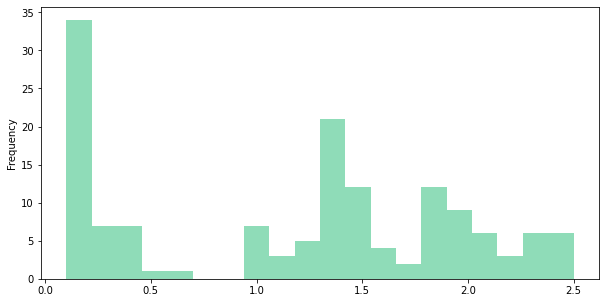

In [9]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### убеждаемся в наличии NaN

In [12]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

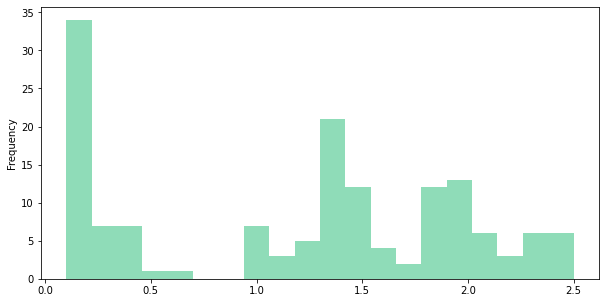

In [13]:
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-2, high=2, size=1)[0], 
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [14]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    1.930193
146    1.930193
147    1.930193
148    1.930193
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


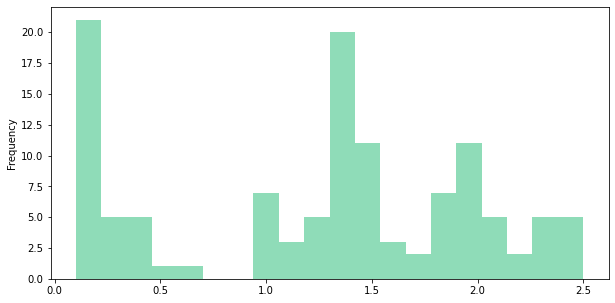

In [15]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [16]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [17]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].std(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,1.072587
1,1.440968
2,2.121104
3,0.773890
4,1.023398
...,...
145,1.205185
146,0.573179
147,1.002636
148,2.230014


### Заполняем пропуски

In [18]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,0.616086
1,0.4,-0.556943
2,0.2,2.305767
3,0.2,0.920895
4,0.2,1.037673
5,0.2,1.580299
6,0.4,1.855402
7,0.1,1.570995
8,0.2,1.720537
9,0.2,1.342296


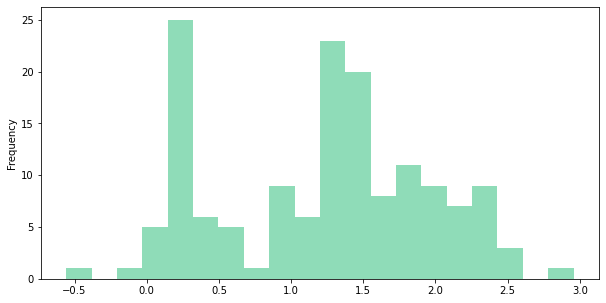

In [19]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Почти похоже на исходный :-)

### Снова генерируем пропуски, но в этот раз удаляем 

In [20]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,1.930193,Virginica
148,6.2,3.4,5.4,1.930193,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [21]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,6.9,2.300000,Virginica
119,6.0,2.2,5.0,1.500000,Virginica
120,6.9,3.2,5.7,2.300000,Virginica
121,5.6,2.8,4.9,2.000000,Virginica
122,7.7,2.8,6.7,2.000000,Virginica
123,6.3,2.7,4.9,1.800000,Virginica
124,6.7,3.3,5.7,2.100000,Virginica
147,6.5,3.0,5.2,1.930193,Virginica
148,6.2,3.4,5.4,1.930193,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [22]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,7.809963,0.2,Setosa
1,4.9,3.0,8.162901,0.2,Setosa
2,4.7,3.2,0.411909,0.2,Setosa
3,4.6,3.1,5.584020,0.2,Setosa
4,5.0,3.6,4.927634,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,5.584020,0.2,Setosa
4,5.0,3.6,4.927634,0.2,Setosa


In [23]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,5.210080,0.3,Setosa
1,5.012766,3.440426,5.210080,0.3,Setosa
2,5.012766,3.440426,5.210080,0.3,Setosa
3,4.600000,3.100000,5.584020,0.2,Setosa
4,5.000000,3.600000,4.927634,0.2,Setosa


## Extra case. Infinity

In [24]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

<ipython-input-24-4ca883aff204>:1: RuntimeWarning: divide by zero encountered in log
  data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,5.076162,inf,Setosa
16,5.4,3.9,4.924614,-inf,Setosa
17,5.1,3.5,6.068336,inf,Setosa
18,5.7,3.8,5.463061,-inf,Setosa


### Гистограмма не строится при наличии inf

In [25]:
data["petal.width"].describe()

count    128.000000
mean            NaN
std             NaN
min            -inf
25%        0.475000
50%        1.300000
75%        1.740403
max             inf
Name: petal.width, dtype: float64

In [26]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойдет не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [27]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

,sepal.length,sepal.width,petal.length,petal.width,variety
14,5.8,4.0,4.660178,0.2,Setosa
15,5.7,4.4,5.076162,NaN,Setosa
16,5.4,3.9,4.924614,NaN,Setosa
17,5.1,3.5,6.068336,NaN,Setosa
18,5.7,3.8,5.463061,NaN,Setosa
19,5.1,3.8,5.703406,0.3,Setosa


### а дальше дело техники...

# Устранение пропусков в линиях/рядах

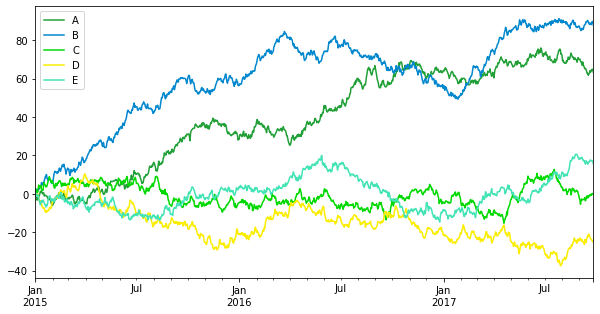

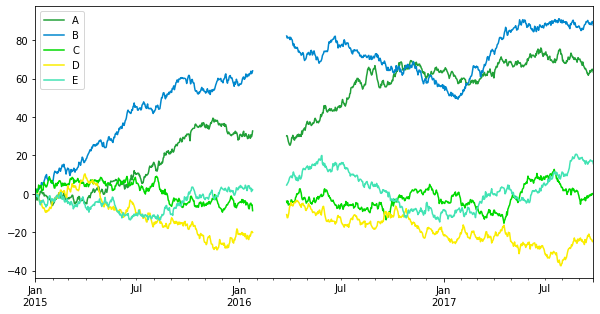

In [28]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

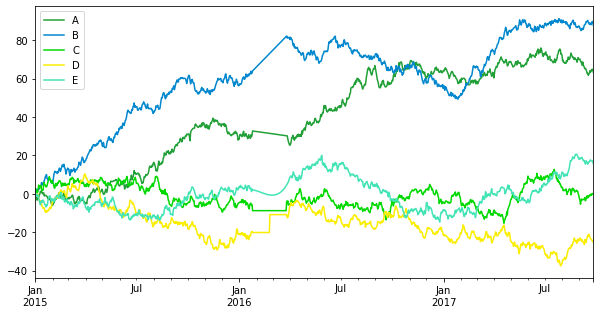

In [29]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [30]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject        Before                                             Recycled  \
type                A          B         C          D         E          A   
2016-02-05  37.722700  72.483408 -6.127082 -21.672534  1.238637  32.257781   
2016-02-06  36.415152  71.905341 -6.124797 -21.156764  0.998557  32.216846   
2016-02-07  36.782129  70.654399 -6.662578 -22.610363  1.560235  32.175912   
2016-02-08  36.022819  69.303696 -7.201920 -21.955053  1.523525  32.134977   
2016-02-09  36.381648  70.356444 -6.434351 -22.000729  1.615240  32.094042   
2016-02-10  36.713308  70.521938 -6.136685 -21.423726  1.638587  32.053107   
2016-02-11  35.976025  71.642905 -5.026404 -20.504130  0.885232  32.012172   
2016-02-12  34.923854  71.515325 -4.406670 -19.606008  0.940147  31.971237   
2016-02-13  35.730408  70.884566 -3.899934 -18.667333  0.229183  31.930302   
2016-02-14  34.592288  71.691705 -3.545616 -19.319876 -0.028871  31.889367   
2016-02-15  35.233824  71.896540 -2.755775 -17.353684  2.052717  31.848432   
2016-02-16  34.049515  72.968327 -1.599730 -17.785667  1.558384  31.807497   
2016-02-17  33.516022  72.049657 -0.581491 -14.859585  0.476188  31.766563   
2016-02-18  33.120368  73.280065 -0.971460 -13.836057  1.607756  31.725628   
2016-02-19  31.804202  74.208166 -1.976270 -12.765664  1.209184  31.684693   
2016-02-20  34.328629  74.815723 -2.369609 -12.796122  3.253091  31.643758   
2016-02-21  34.161476  74.595582 -2.308916 -12.052674  2.386171  31.602823   
2016-02-22  35.340361  73.970722 -3.037004 -12.490313  2.384522  31.561888   
2016-02-23  34.082446  75.289081 -3.273547 -13.079900  2.707960  31.520953   
2016-02-24  32.608579  74.327604 -2.843746 -12.457361  2.418560  31.480018   

subject                                               
type                B         C          D         E  
2016-02-05  67.257898 -8.756407 -20.125019  1.187723  
2016-02-06  67.555414 -8.756407 -20.125019  1.082794  
2016-02-07  67.852931 -8.756407 -20.125019  0.976206  
2016-02-08  68.150448 -8.756407 -20.125019  0.868504  
2016-02-09  68.447964 -8.756407 -20.125019  0.760232  
2016-02-10  68.745481 -8.756407 -20.125019  0.651933  
2016-02-11  69.042997 -8.756407 -20.125019  0.544150  
2016-02-12  69.340514 -8.756407 -20.125019  0.437429  
2016-02-13  69.638030 -8.756407 -20.125019  0.332311  
2016-02-14  69.935547 -8.756407 -20.125019  0.229342  
2016-02-15  70.233063 -8.756407 -20.125019  0.129065  
2016-02-16  70.530580 -8.756407 -20.125019  0.032023  
2016-02-17  70.828097 -8.756407 -20.125019 -0.061240  
2016-02-18  71.125613 -8.756407 -20.125019 -0.150180  
2016-02-19  71.423130 -8.756407 -20.125019 -0.234252  
2016-02-20  71.720646 -8.756407 -20.125019 -0.312915  
2016-02-21  72.018163 -8.756407 -20.125019 -0.385623  
2016-02-22  72.315679 -8.756407 -20.125019 -0.451833  
2016-02-23  72.613196 -8.756407 -20.125019 -0.511002  
2016-02-24  72.910712 -8.756407 -20.125019 -0.562586